<a href="https://colab.research.google.com/github/twelvesense/first-repository/blob/master/GoCvNode12.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **프로젝트:  End-to-End  OCR**

#1: 사전준비

##1-1: 라이브러리

In [7]:
!pip install keras_ocr
!pip install lmdb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 42 kB 855 kB/s 
     |████████████████████████████████| 604 kB 17.7 MB/s 
     |████████████████████████████████| 9.5 MB 41.3 MB/s 
     |████████████████████████████████| 944 kB 56.5 MB/s 
     |████████████████████████████████| 50 kB 6.9 MB/s 
  Created wheel for validators: filename=validators-0.20.0-py3-none-any.whl size=19582 sha256=ed3fc4f5f267620df706c1fa060ee7b9b2edfa6ee7843c660dc1bb406efacf07
  Stored in directory: /root/.cache/pip/wheels/5f/55/ab/36a76989f7f88d9ca7b1f68da6d94252bb6a8d6ad4f18e04e9
Successfully built validators
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [8]:
import numpy as np
import cv2
import keras_ocr
from keras_ocr.detection import Detector

import re
import six
import math
import lmdb
import os
import numpy as np

import PIL
from PIL import Image, ImageDraw
from IPython.display import display
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.utils import Sequence
from tensorflow.keras import backend as K
from tensorflow.keras.models import load_model

print(tf.__version__)
print(np.__version__)
print(PIL.__version__)
print(cv2.__version__)
print(keras_ocr.__version__)

2.8.2
1.21.6
7.1.2
4.6.0
0.9.1


## 1-2: 데이터셋

In [10]:
from google.colab import drive
drive.mount('/content/drive')
PATH_COLAB = '/content/drive/MyDrive/colab/GoCvNode12'

Mounted at /content/drive


In [11]:
HOME_DIR = os.path.join(PATH_COLAB, 'data')
TRAIN_DATA_PATH = HOME_DIR+'/MJ/MJ_train'
VALID_DATA_PATH = HOME_DIR+'/MJ/MJ_valid'
TEST_DATA_PATH = HOME_DIR+'/MJ/MJ_test'
SAMPLE_IMG_PATH = HOME_DIR + '/sample.jpg'
print(TEST_DATA_PATH)

/content/drive/MyDrive/colab/GoCvNode12/data/MJ/MJ_test


In [12]:
detector = Detector()

Looking for /root/.keras-ocr/craft_mlt_25k.h5


# 2: 데이터

original image width:130, height:31
target_img_size:(100, 32)
display img shape:(100, 32, 3)
label:slinking


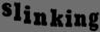

original image width:67, height:31
target_img_size:(69, 32)
display img shape:(69, 32, 3)
label:REMODELERS


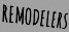

original image width:169, height:31
target_img_size:(100, 32)
display img shape:(100, 32, 3)
label:Chronographs


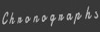

original image width:110, height:31
target_img_size:(100, 32)
display img shape:(100, 32, 3)
label:Impeaching


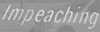

In [14]:
# 데이터셋 이미지 확인; 4개, shape, 라벨

# lmdb 데이터를 env 변수에 읽어오기
env = lmdb.open(TEST_DATA_PATH, 
                max_readers=32, 
                readonly=True, 
                lock=False, 
                readahead=False, 
                meminit=False)

# 불러온 데이터를 txn(transaction) 변수로 열기
with env.begin(write=False) as txn:
    for index in range(1, 5):
        # index를 이용해서 라벨 키와 이미지 키를 만들면
        # txn에서 라벨과 이미지를 읽어올 수 있어요
        label_key = 'label-%09d'.encode() % index
        label = txn.get(label_key).decode('utf-8')
        img_key = 'image-%09d'.encode() % index
        imgbuf = txn.get(img_key)
        buf = six.BytesIO()
        buf.write(imgbuf)
        buf.seek(0)

        # 이미지는 버퍼를 통해 읽어오기 때문에 
        # 버퍼에서 이미지로 변환하는 과정이 다시 필요해요
        try:
            img = Image.open(buf).convert('RGB')

        except IOError:
            img = Image.new('RGB', (100, 32))
            label = '-'

        # 원본 이미지 크기를 출력해 봅니다
        width, height = img.size
        print('original image width:{}, height:{}'.format(width, height))
        
        # 이미지 비율을 유지하면서 높이를 32로 바꿀거에요
        # 하지만 너비를 100보다는 작게하고 싶어요
        target_width = min(int(width*32/height), 100)
        target_img_size = (target_width,32)        
        print('target_img_size:{}'.format(target_img_size))        
        img = np.array(img.resize(target_img_size)).transpose(1,0,2)

        # 이제 높이가 32로 일정한 이미지와 라벨을 함께 출력할 수 있어요       
        print('display img shape:{}'.format(img.shape))
        print('label:{}'.format(label))
        display(Image.fromarray(img.transpose(1,0,2).astype(np.uint8)))

In [15]:
class MJDatasetSequence(Sequence):
    # 객체를 초기화 할 때 lmdb를 열어 env에 준비해둡니다
    # 또, lmdb에 있는 데이터 수를 미리 파악해둡니다
    def __init__(self, 
                 dataset_path,
                 label_converter,
                 batch_size=1,
                 img_size=(100,32),
                 max_text_len=22,
                 is_train=False,
                 character='') :
        
        self.label_converter = label_converter
        self.batch_size = batch_size
        self.img_size = img_size
        self.max_text_len = max_text_len
        self.character = character
        self.is_train = is_train
        self.divide_length = 100

        self.env = lmdb.open(dataset_path, max_readers=32, readonly=True, lock=False, readahead=False, meminit=False)
        with self.env.begin(write=False) as txn:
            self.num_samples = int(txn.get('num-samples'.encode()))
            self.index_list = [index + 1 for index in range(self.num_samples)]
        
    def __len__(self):
        return math.ceil(self.num_samples/self.batch_size/self.divide_length)
    
    # index에 해당하는 image와 label을 읽어옵니다
    # 위에서 사용한 코드와 매우 유사합니다
    # label을 조금 더 다듬는 것이 약간 다릅니다
    def _get_img_label(self, index):
        with self.env.begin(write=False) as txn:
            label_key = 'label-%09d'.encode() % index
            label = txn.get(label_key).decode('utf-8')
            img_key = 'image-%09d'.encode() % index
            imgbuf = txn.get(img_key)

            buf = six.BytesIO()
            buf.write(imgbuf)
            buf.seek(0)
            try:
                img = Image.open(buf).convert('RGB')

            except IOError:
                img = Image.new('RGB', self.img_size)
                label = '-'
            width, height = img.size
            
            target_width = min(int(width*self.img_size[1]/height), self.img_size[0])
            target_img_size = (target_width, self.img_size[1])
            img = np.array(img.resize(target_img_size)).transpose(1,0,2)
            # label을 약간 더 다듬습니다
            label = label.upper()
            out_of_char = f'[^{self.character}]'
            label = re.sub(out_of_char, '', label)
            label = label[:self.max_text_len]

        return (img, label)
    
    # __getitem__은 약속되어있는 메서드입니다
    # 이 부분을 작성하면 slice할 수 있습니다
    # 자세히 알고 싶다면 아래 문서를 참고하세요
    # https://docs.python.org/3/reference/datamodel.html#object.__getitem__
    # 
    # 1. idx에 해당하는 index_list만큼 데이터를 불러
    # 2. image와 label을 불러오고 
    # 3. 사용하기 좋은 inputs과 outputs형태로 반환합니다
    def __getitem__(self, idx):
        # 1.
        batch_indicies = self.index_list[
            idx*self.batch_size:
            (idx+1)*self.batch_size
        ]
        input_images = np.zeros([self.batch_size, *self.img_size, 3])
        labels = np.zeros([self.batch_size, self.max_text_len], dtype='int64')

        input_length = np.ones([self.batch_size], dtype='int64') * self.max_text_len
        label_length = np.ones([self.batch_size], dtype='int64')

        # 2.
        for i, index in enumerate(batch_indicies):
            img, label = self._get_img_label(index)
            encoded_label = self.label_converter.encode(label)
            # 인코딩 과정에서 '-'이 추가되면 max_text_len보다 길어질 수 있어요
            if len(encoded_label) > self.max_text_len:
                continue
            width = img.shape[0]
            input_images[i,:width,:,:] = img
            labels[i,0:len(encoded_label)] = encoded_label
            label_length[i] = len(encoded_label)
        
        # 3.
        inputs = {
            'input_image': input_images,
            'label': labels,
            'input_length': input_length,
            'label_length': label_length,
        }
        outputs = {'ctc': np.zeros([self.batch_size, 1])}

        return inputs, outputs

## 2-1. Text encode, decode

In [18]:
# 인식대상
NUMBERS = "0123456789"
ENG_CHAR_UPPER = "ABCDEFGHIJKLMNOPQRSTUVWXYZ"
TARGET_CHARACTERS = ENG_CHAR_UPPER + NUMBERS
print(f"The total number of characters is {len(TARGET_CHARACTERS)}")

The total number of characters is 36


In [19]:
# text encode, decode
class LabelConverter(object):

     def __init__(self, character):
         self.character = "-" + character
         self.label_map = dict()
         for i, char in enumerate(self.character):
             self.label_map[char] = i

     def encode(self, text):
         encoded_label = []
         for i, char in enumerate(text):
             if i > 0 and char == text[i - 1]:
                 encoded_label.append(0)    # 같은 문자 사이에 공백 문자 label을 삽입
             encoded_label.append(self.label_map[char])         

         return np.array(encoded_label)

     def decode(self, encoded_label):
         target_characters = list(self.character)
         decoded_label = ""
         for encode in encoded_label:
             decoded_label += self.character[encode]
         return decoded_label

In [20]:
# Text encode, decode 사용 예
label_converter = LabelConverter(TARGET_CHARACTERS)

encdoded_text = label_converter.encode('HELLO')
print("Encdoded_text: ", encdoded_text)
decoded_text = label_converter.decode(encdoded_text)
print("Decoded_text: ", decoded_text)

Encdoded_text:  [ 8  5 12  0 12 15]
Decoded_text:  HEL-LO


##2-2: 데이터 불러오기

In [22]:
BATCH_SIZE = 128

In [23]:
# 데이터셋 준비
train_set = MJDatasetSequence(TRAIN_DATA_PATH, label_converter, batch_size=BATCH_SIZE, character=TARGET_CHARACTERS, is_train=True)
val_set = MJDatasetSequence(VALID_DATA_PATH, label_converter, batch_size=BATCH_SIZE, character=TARGET_CHARACTERS)

# 3: 모델

##3-1: 기본 설정 및 함수

In [24]:
BATCH_SIZE = 128

In [25]:
# CTC loss를 계산하기 위한 Lambda 함수
def ctc_lambda_func(args): 
    labels, y_pred, label_length, input_length = args
    y_pred = y_pred[:, 2:, :]
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

In [26]:
# crnn_model
def build_crnn_model(input_shape=(100,32,3), characters=TARGET_CHARACTERS):
    num_chars = len(characters)+2
    image_input = layers.Input(shape=input_shape, dtype='float32', name='input_image')
    
    # Build CRNN model
    conv = layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(image_input)
    conv = layers.MaxPooling2D(pool_size=(2, 2))(conv)
    conv = layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.MaxPooling2D(pool_size=(2, 2))(conv)
    conv = layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.MaxPooling2D(pool_size=(1, 2))(conv)
    conv = layers.Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.BatchNormalization()(conv)
    conv = layers.Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.BatchNormalization()(conv)
    conv = layers.MaxPooling2D(pool_size=(1, 2))(conv)     
    feature = layers.Conv2D(512, (2, 2), activation='relu', kernel_initializer='he_normal')(conv)
    sequnce = layers.Reshape(target_shape=(24, 512))(feature)
    sequnce = layers.Dense(64, activation='relu')(sequnce)
    sequnce = layers.Bidirectional(layers.LSTM(256, return_sequences=True))(sequnce)
    sequnce = layers.Bidirectional(layers.LSTM(256, return_sequences=True))(sequnce)
    y_pred = layers.Dense(num_chars, activation='softmax', name='output')(sequnce)    

    labels = layers.Input(shape=[22], dtype='int64', name='label')
    input_length = layers.Input(shape=[1], dtype='int64', name='input_length')
    label_length = layers.Input(shape=[1], dtype='int64', name='label_length')
    loss_out = layers.Lambda(ctc_lambda_func, output_shape=(1,), name="ctc")(
        [labels, y_pred, label_length, input_length]
    )
    model_input = [image_input, labels, input_length, label_length]
    model = Model(
        inputs=model_input,
        outputs=loss_out
    )
    return model

## 3-2: 학습

In [64]:
# 모델 준비
model = build_crnn_model()

# 모델 컴파일
optimizer = tf.keras.optimizers.Adadelta(learning_rate=0.1, clipnorm=5)
model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=optimizer)

In [65]:
# 학습된 모델의 가중치가 저장된 경로
checkpoint_path = HOME_DIR + '/model_checkpoint.hdf5'

# 훈련이 빨리 끝날 수 있도록 ModelCheckPoint와 EarlyStopping을 사용
ckp = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_path, monitor='val_loss',
    verbose=1, save_best_only=True, save_weights_only=True
)
earlystop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=4, verbose=0, mode='min'
)
history = model.fit(train_set,
          steps_per_epoch=len(train_set),
          epochs=20,
          validation_data=val_set,
          validation_steps=len(val_set),
          callbacks=[ckp, earlystop])

Epoch 1/20
565/565 [==============================] - ETA: 0s - loss: 25.3234
Epoch 1: val_loss improved from inf to 23.49134, saving model to /content/drive/MyDrive/colab/GoCvNode12/data/model_checkpoint.hdf5
565/565 [==============================] - 96s 153ms/step - loss: 25.3234 - val_loss: 23.4913
Epoch 2/20
565/565 [==============================] - ETA: 0s - loss: 14.1251
Epoch 2: val_loss improved from 23.49134 to 9.53518, saving model to /content/drive/MyDrive/colab/GoCvNode12/data/model_checkpoint.hdf5
565/565 [==============================] - 85s 151ms/step - loss: 14.1251 - val_loss: 9.5352
Epoch 3/20
565/565 [==============================] - ETA: 0s - loss: 7.0004
Epoch 3: val_loss improved from 9.53518 to 6.46903, saving model to /content/drive/MyDrive/colab/GoCvNode12/data/model_checkpoint.hdf5
565/565 [==============================] - 85s 150ms/step - loss: 7.0004 - val_loss: 6.4690
Epoch 4/20
565/565 [==============================] - ETA: 0s - loss: 5.0865
Epoch 4:

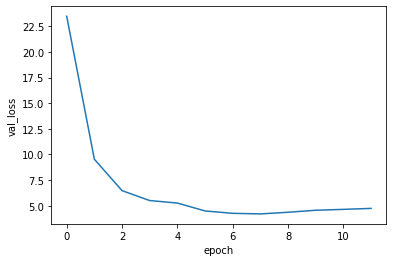

In [66]:
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('val_loss')
plt.show()

##3-3: 평가

In [67]:
# 데이터셋과 모델을 불러오기
test_set = MJDatasetSequence(TEST_DATA_PATH, label_converter, batch_size=BATCH_SIZE, character=TARGET_CHARACTERS)

# crnn 모델은 입력이 복잡한 구조이므로, 입력중 'input_image' 부분만 사용한 inference 전용 모델 만들기
input_data = model.get_layer('input_image').output
y_pred = model.get_layer('output').output
model_pred = Model(inputs=input_data, outputs=y_pred)

In [68]:
#inference 결과를 글자로 변경하기
def decode_predict_ctc(out, chars = TARGET_CHARACTERS):
    results = []
    indexes = K.get_value(
        K.ctc_decode(
            out, input_length=np.ones(out.shape[0]) * out.shape[1],
            greedy=False , beam_width=5, top_paths=1
        )[0][0]
    )[0]
    text = ""
    for index in indexes:
        text += chars[index]
    results.append(text)
    return results

In [69]:
# Keras OCR Detector를 이용한 이미지 문자 위치 검출
def detect_text(img_path):
    img_pil = Image.open(img_path)
    img_pil = img_pil.resize((800, 800))
    img_draw=ImageDraw.Draw(img_pil)
    result_img = img_pil
    
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img)
    img = tf.image.resize(img, (800, 800))
    # 배치 크기를 위해서 dimension을 확장 및 kera-ocr의 입력 차원에 따른 H,W,C 설정
    img = img[tf.newaxis, :, :, : ]
    det_result = detector.detect(img.numpy())
    # 배치의 첫 번째 결과
    ocr_result = det_result[0] 
    
    # 시각화 위한 x와 y좌표 변경 (앞선 h dimension으로 인해 y,x로 표기)
    cropped_imgs = []
    for text_result in ocr_result:
        img_draw.polygon(text_result, outline='red')
        x_min = text_result[:,0].min() - 5
        x_max = text_result[:,0].max() + 5
        y_min = text_result[:,1].min() - 5
        y_max = text_result[:,1].max() + 5
        word_box = [x_min, y_min, x_max, y_max]
        cropped_imgs.append(img_pil.crop(word_box))

    return result_img, cropped_imgs

In [70]:
def recognize_img(pil_img, input_img_size=(100,32)):
    pil_img = pil_img.resize(input_img_size)
    np_img = np.array(pil_img)
    np_img = np.transpose(np_img, (1, 0, 2))
    np_img = np_img[np.newaxis, :, :, :]
    output = model_pred.predict(np_img)
    result = decode_predict_ctc(output, chars="-"+TARGET_CHARACTERS)[0].replace('-','')
    print("Result: \t", result)
    display(Image.fromarray(np.array(pil_img).astype(np.uint8)))

In [71]:
def OCR_E2E(img):
  # detection
  img_pil, cropped_img = detect_text(img)
  display(img_pil)

  # recognition
  for _img in cropped_img:
    recognize_img(_img)

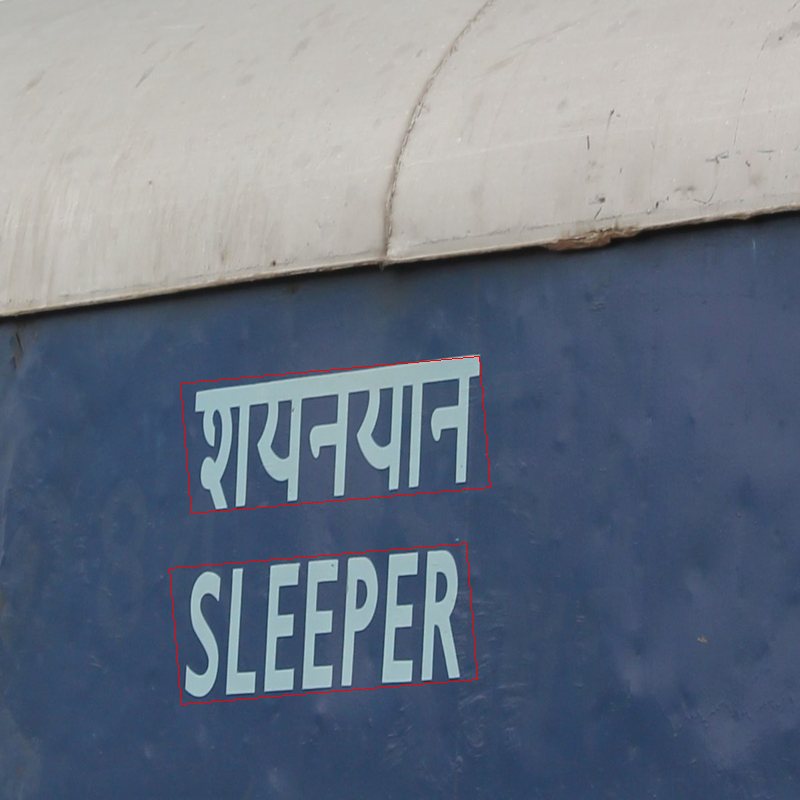

Result: 	 RARIF9999999999999999999


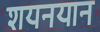

Result: 	 SLEEPER9999999999999999


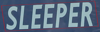

In [72]:
OCR_E2E(SAMPLE_IMG_PATH)

> 이미지의 문자열인 SLEEPER에 대해서, 인식결과는  이므로,<br>
7개 문자중 7개의 모든 문자가 정확하게 100% 인식되었다.

#회고

> OCR의 detection과 recognition 과정을 학습할 수 있었다.<br>
OCR을 위한 loss함수에 대해 새롭게 배울 수 있었다.
